# Spike synchrony
1. Cross correlation
2. Unitary event analysis
3. My method

In [13]:
import elephant
import quantities as pq
from neo.core import AnalogSignal
from neo import SpikeTrain
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import random
import viziphant.unitary_event_analysis as vue
from scipy.stats import norm, binom
from seaborn import color_palette

Simulate 2 neurons, synchronized to the same underlying oscillation (aka, both have a rhythmic and sycnhronized firing rate)

In [16]:
np.random.seed(1224)
fs = 1000
times = np.arange(0, 2, 1/fs)
freq = 20
mean_rate = 60
osc = np.sin(2 * np.pi * times[:] * freq)
osc_rate = mean_rate * osc
osc_rate += mean_rate #make sure rate is always positive
sim_spike_rate = AnalogSignal(np.expand_dims(osc_rate, 1), units='Hz', sampling_rate=1000*pq.Hz)
st1 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)
st2 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)

 ## Cross correlation
 
 See *spiketrain_analyses*, **autocorrelation** section. This is the same analysis, but instead of comparing a spike train with itself, here we're comparing two spike trains.
 


Text(0, 0.5, 'Count')

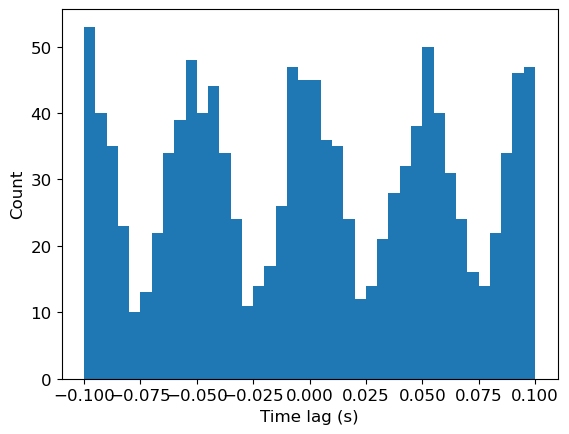

In [54]:
spikes1 = np.squeeze(st1)
spikes2 = np.squeeze(st2)

binsize = .005
max_lag = .1
start_win, stop_win = times[0] + max_lag, times[-1] - max_lag
histo_bins = int((max_lag*2)/binsize)

spike_diffs = []

for i, spike1 in enumerate(spikes1):
    if spike1>start_win and spike1<stop_win:
        for j, spike2 in enumerate(spikes2):
                spike_diff = spike1 - spike2
                if np.abs(spike_diff)<max_lag: 
                    spike_diffs.append(spike1 - spike2)
        
counts, bins, patches = plt.hist(spike_diffs, bins=histo_bins)
plt.xlabel('Time lag (s)')
plt.ylabel('Count')

TODO: Examples where a metric is computed from the cross correlation?

## Unitary event analysis

Unitary event analysis essentially computes the number of synchronous spikes [[1]](#References). Because some number of synchronous spikes are expected by chance, this number is then compared to an 'expected' number of spikes. 

In [86]:
# Compute number of synchronous spikes
binned_st1 = elephant.conversion.BinnedSpikeTrain(st1, bin_size=5*pq.ms) #Binarize spike train
binned_st2 = elephant.conversion.BinnedSpikeTrain(st2, bin_size=5*pq.ms) #Binarize spike train

sync_events = np.logical_and(binned_st1.to_bool_array(),binned_st2.to_bool_array()) #Find where spikes occurred in both spiketrains
n_events = np.sum(sync_events)
n_bins = sync_events.shape[1]
print('Number of bins: '+ str(n_bins))
print('Number of synchronous events: ' + str(n_events))

Number of bins: 400
Number of synchronous events: 43


Now, let's compare this number with how much we would expect by chance. There are a few ways to compute this. Analytically,  we have two spike trains with a mean rate of 60Hz. Therefore, each neuron spikes .3 times per 5ms, and for any 5ms bin, the probability of both neurons spiking is .09. We can calculate the probability that we observe 43 synchronous events or greater using a binomial distribution.

In [88]:
# Analytic
p = binom.sf(n_events, n_bins, .09)
print('Analytic probability: '+ str(p))

Analytic probability: 0.09754615335115961


Though simple and efficient, this method works only when the firing rate of neurons is stationary over time. However, the firing rate of neurons can change over time, in ways that are correlated with one another that may be spurious to this analysis. This can occur with the onset of a stimulus, or a neuromodulator.

To deal with non-stationarities, there are several methods to create surrogate spike trains, which the actual number of synchronous events can be compared with [[2]](#References). Surrogates are commonly created by dithering (or jittering) a spike train by randomly moving each spike by some time within some small time frame. Alternatively, surrogates can be created by randomly shifting spike trains against each other, conserving the original structure of each spike train but requiring ultimately large time shifts. When analyzing synchrony evoked by a stimulus, spike trains can be shifted across trials, such that the number of synchronous events can be compared with the number of synchronous events found when comparing neurons recorded in different trials. However, this analysis assumes stationarity can be assumed across trials, which is generally unlikely.

Here, let's dither to create surrogate spike trains, and compare the actual number of synchronous events with this distribution.

In [101]:
# Compare with surrogate spike trains
np.random.seed(2022)
surr_evts = []
surr_sts = elephant.spike_train_surrogates.dither_spikes(st2, 10*pq.ms, n_surrogates=200)
for surr_st in surr_sts:
    binned_surr_st = elephant.conversion.BinnedSpikeTrain(surr_st, bin_size=5*pq.ms) #Binarize spike train
    sync_events = np.logical_and(binned_st1.to_bool_array(),binned_surr_st.to_bool_array()) #Find where spikes occurred in both spiketrains
    surr_evts.append(np.sum(sync_events))

Dithered probability: 0.10832211715896994


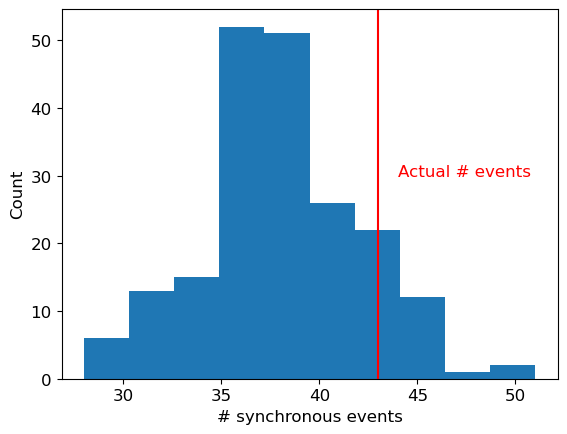

In [108]:
plt.hist(surr_evts)
plt.axvline(n_events, color='red')
plt.xlabel('# synchronous events')
plt.ylabel('Count')
plt.text(n_events+1, 30, 'Actual # events', color='red')

z_score = (n_events - np.mean(surr_evts)) / np.std(surr_evts)

dith_p = norm.sf(z_score)
print('Dithered probability: '+ str(dith_p))

Now, let's simulate two spike trains that only become synchronous after 1s. 

In [70]:
np.random.seed(2022)
fs = 1000
times = np.arange(0, 2, 1/fs)
freq = 20
mean_rate = 60
osc = np.sin(2 * np.pi * times[:] * freq)
osc_rate = np.zeros(len(times))
osc_rate[1000:] = mean_rate * osc[:1000]
osc_rate += mean_rate #make sure rate is always positive
sim_spike_rate = AnalogSignal(np.expand_dims(osc_rate, 1), units='Hz', sampling_rate=1000*pq.Hz)
st1 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)
st2 = elephant.spike_train_generation.inhomogeneous_poisson_process(rate=sim_spike_rate, refractory_period=3*pq.ms)

We can calculate how synchrony changes over time using elephant's jointJ_window_analysis function, and plot it using the plot_ue function from viziphant (elephant's companion visualization package).

In [71]:
spiketrains = [[st1, st2]]
random.seed(2022)
UEs = elephant.unitary_event_analysis.jointJ_window_analysis(spiketrains, bin_size=5*pq.ms, winsize=500*pq.ms, winstep=50*pq.ms, pattern_hash=[3])

FigureUE(axes_spike_events=<AxesSubplot: title={'center': 'Spike Events'}, ylabel='Trial'>, axes_spike_rates=<AxesSubplot: title={'center': 'Spike Rates'}, ylabel='Hz'>, axes_coincident_events=<AxesSubplot: title={'center': 'Coincident Events'}, ylabel='Trial'>, axes_coincidence_rates=<AxesSubplot: title={'center': 'Coincidence Rates'}, ylabel='Hz'>, axes_significance=<AxesSubplot: title={'center': 'Statistical Significance'}>, axes_unitary_events=<AxesSubplot: title={'center': 'Unitary Events'}, xlabel='Time (ms)', ylabel='Trial'>)

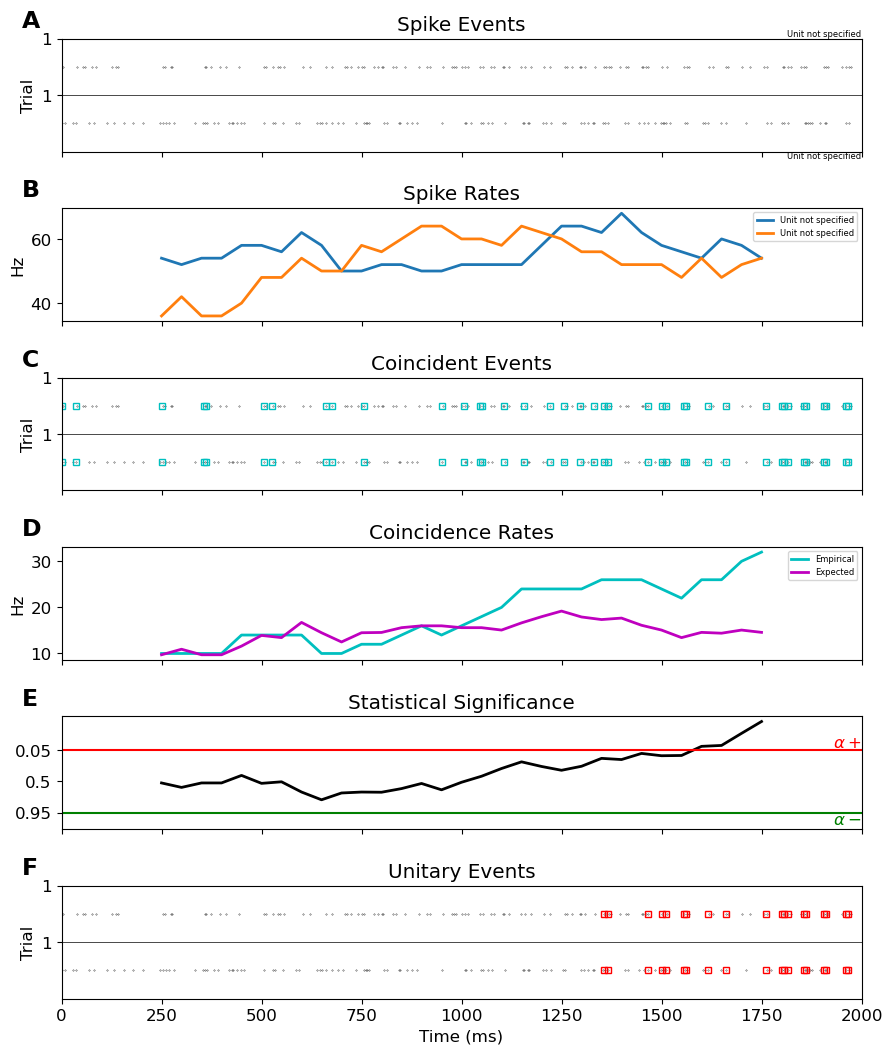

In [72]:
vue.plot_ue(spiketrains, UEs, significance_level=0.05)

Elephant's visualization shows many coincident events. Additionally, the actual coincidence rate is generally higher than the expected, as calculated analytically. However, the windows only reach significance around 1s, and only coincident events in these windows are marked as unitary events.

## Spike-triggered population rate

Alternatively, spike-spike synchrony can be computed as the spike-triggered population rate (stPR), or the firing rate of other neurons when one neuron fires [[3]](#References). 

In [46]:
#stPR (uncorrected)
spike_sr = 1000
sigma=5*pq.ms
kernel = elephant.kernels.GaussianKernel(sigma=sigma)
rate = elephant.statistics.instantaneous_rate(st1, sampling_period=1/spike_sr * pq.s,
                                              kernel=kernel, center_kernel=True)
stPRs = []
spikes2 = np.squeeze(st2)
for spike in spikes2:
    stPRs.append(float(rate[int(round(spike * spike_sr, 4))]))
    
mean_stPR = np.mean(stPRs)
print('Mean firing rate: ' + str(np.mean(rate)))
print('Mean stPR: ' + str(mean_stPR*pq.Hz))    

Mean firing rate: 56.49112231023921 Hz
Mean stPR: 82.838122333807 Hz


The spike-triggered firing rate is greater than the overall mean firing rate, meaning neuron 2 is more likely to fire around when neuron 1 is firing.

Additionally, for each spike, we can get the firing rate in a surrounding window of time. This will allow us to see at what timescale the firing rate of neuron 1 increases when neuron 2 fires.

Text(0, 0.5, 'Firing rate (Hz)')

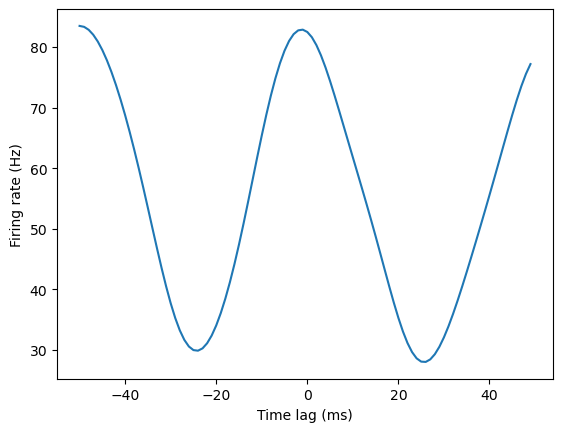

In [45]:
spike_sr = 1000
window = 100
sigma=5*pq.ms
kernel = elephant.kernels.GaussianKernel(sigma=sigma)
rate = elephant.statistics.instantaneous_rate(st1, sampling_period=1/spike_sr * pq.s,
                                              kernel=kernel, center_kernel=True)
rate = np.asarray(rate)
stPR_segs = []
spikes2 = np.squeeze(st2)
for spike in spikes2:
    spike = float(spike)
    if spike > window/spike_sr and times[-1] - spike > window/spike_sr: #If window entirely within times analyzed
        rate_seg = rate[int(round(spike*spike_sr))-int(window/2):int(round(spike*spike_sr))+int(window/2)]
        stPR_segs.append(rate_seg)
    
stPRs_arr = np.asarray(stPR_segs)
stPRs_arr = np.squeeze(stPRs_arr)

plt.plot(np.arange(-window/2, window/2, 1), np.mean(stPRs_arr,0))
plt.xlabel('Time lag (ms)')
plt.ylabel('Firing rate (Hz)')

We have essentially created a cross correlation figure, using the firing rate of unit 1. 

However, this method is biased by the mean firing rate of the population: if neurons fire more in general, the stPR will be higher. Thus, just as with unitary event analysis, we need to find a method to control for the overall firing rate of the population. 

In the original paper for this method, the authors did so via a shuffling method. Though their exact method does not suit our data, we can implement something similar by comparing with surrogate spike trains as we did before. 

Dithered probability: 0.04831465146396294


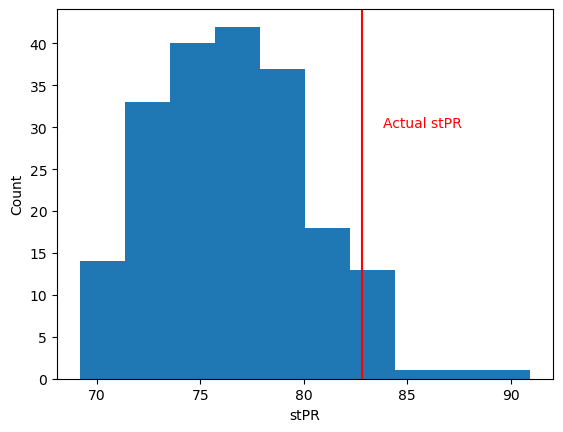

In [48]:
#Surrogate vs. real stPR
np.random.seed(2022)
surr_stPRs = []
surr_sts = elephant.spike_train_surrogates.dither_spikes(st2, 10*pq.ms, n_surrogates=200)
for surr_st in surr_sts:
    stPRs = []
    surr_spikes = np.squeeze(surr_st)
    for spike in surr_spikes:
        stPRs.append(float(rate[int(round(spike * spike_sr, 4))]))
    surr_stPRs.append(np.mean(stPRs))
    
plt.hist(surr_stPRs)
plt.axvline(mean_stPR, color='red')
plt.xlabel('stPR')
plt.ylabel('Count')
plt.text(mean_stPR+1, 30, 'Actual stPR', color='red')

z_score = (mean_stPR - np.mean(surr_stPRs)) / np.std(surr_stPRs)

dith_p = norm.sf(z_score)
print('Dithered probability: '+ str(dith_p))

Alternatively, we can control for the overall firing rate of the population (and its nonstationarities) in our measurement of the firing rate itself. We can isolate the fine-timescale deviations from the mean firing rate by substracting out the longer-timescale estimate of firing rate. Specifically, this method measures firing rate on a fine time-scale using a narrow kernel, and subtracts the firing rate measured on a slow timescale from this firing rate. 

In [ ]:
#Fine timescale stPR

We can get a more exact idea of what firing rate changes this timescale is estimating by plotting how each kernel estimates the firing rate of a single spike.

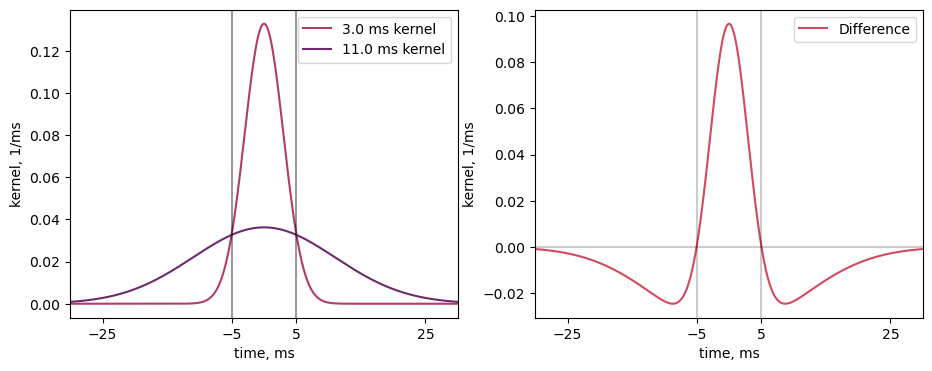

In [15]:
#Kernel design
fast_kernel_sigma = 3*pq.ms
slow_kernel_sigma = 11*pq.ms
spiketrain = SpikeTrain([-1, 0, 1], t_start=-1, t_stop=1, units='s')
time_array = np.linspace(-50, 50, num=1001) * pq.ms
kernel = elephant.kernels.GaussianKernel(sigma=fast_kernel_sigma)
fast_kernel_time = kernel(time_array)
fast_rate = elephant.statistics.instantaneous_rate(spiketrain, sampling_period=1 / 100000 * pq.s,
                                       kernel=kernel, center_kernel=True)
kernel = elephant.kernels.GaussianKernel(sigma=slow_kernel_sigma)
slow_kernel_time = kernel(time_array)
slow_rate = elephant.statistics.instantaneous_rate(spiketrain, sampling_period=1 / 100000 * pq.s,
                                       kernel=kernel, center_kernel=True)

colors = color_palette("flare")
plt.figure(figsize=(11, 4))
plt.subplot(1,2,1)
plt.plot(time_array, fast_kernel_time, color=colors[3])
plt.plot(time_array, slow_kernel_time, color=colors[-1])
plt.legend([str(fast_kernel_sigma)+' kernel', str(slow_kernel_sigma)+' kernel', 'Difference'])
plt.xlabel("time, ms")
plt.ylabel("kernel, 1/ms")
plt.xticks([-25, -5, 5, 25])
plt.axvline(-5, color='black', alpha=.4)
plt.axvline(5, color='black', alpha=.4)
plt.xlim(-30, 30)

plt.subplot(1,2,2)
plt.plot(time_array, fast_kernel_time-slow_kernel_time, color=colors[2])
plt.xlabel("time, ms")
plt.ylabel("kernel, 1/ms")
plt.axvline(-5, color='black', alpha=.2)
plt.axvline(5, color='black', alpha=.2)
plt.axhline(0, color='black', alpha=.2)
plt.xticks([-25, -5, 5, 25])
plt.xlim(-30, 30)
plt.legend(['Difference'])

The narrower kernel results in an estimatation of firing rate that only increases immediately surrounding the spike, but increases to a much higher degree. Specifically, using a 3ms and 11ms sigma for the fine and slow time-scale kernels, respectively, the fine-timescale firing rate is increased in the 10ms surrounding the spike, but decreased in the remaining 60ms. Therefore, this metric will be positive when the difference between two spike times is less than 5ms, or negative when the difference is between 5 and ~30ms. 

Using this method, the timescales of the kernels should be carefully designed to reflect what the study would like to define as synchrony, and what general fluctuations should be removed. 

# References
1. Grün, S., Diesmann, M., Grammont, F., Riehle, A., & Aertsen, A. (1999). Detecting unitary events without discretization of time. Journal of neuroscience methods, 94(1), 67-79
2. Grün, S. (2009). Data-driven significance estimation for precise spike correlation. Journal of Neurophysiology, 101(3), 1126–1140. https://doi.org/10.1152/JN.00093.2008/ASSET/IMAGES/LARGE/Z9K0030993390009.JPEG
3. Okun, M., Steinmetz, N. A., Cossell, L., Iacaruso, M. F., Ko, H., Barthó, P., Moore, T., Hofer, S. B., Mrsic-Flogel, T. D., Carandini, M., & Harris, K. D. (2015). Diverse coupling of neurons to populations in sensory cortex. Nature, 521(7553), 511. https://doi.org/10.1038/NATURE14273